# Easy or Hard?

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import mlp

import matplotlib.pyplot as plt

In [4]:
# import data
train_data = pd.read_csv('MNIST_train.csv', index_col='ID')
val_data   = train_data[55000:]
train_data = train_data[:55000]
test_data  = pd.read_csv('MNIST_test.csv', index_col='ID')

train_data_unlabeled = train_data.drop(' Label', axis=1)
val_data_unlabeled   = val_data.drop(' Label', axis=1)
test_data_unlabeled  = test_data.drop(' Label', axis=1)

mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


**Naive statistical analysis**
Here, we just compute:
- prediction accuracy for each number, averaged over all algorithms
- accuracy of each algorithm
- accuracy of each algorithm for each number

In [5]:
# compute average accuracy
correct = train_data
correct['num_correct'] = train_data_unlabeled.apply(lambda row: row.sum(),1)

average_accuracy = pd.DataFrame(index=['num_correct'])
for i in range(10):
    average_accuracy[i] = correct.loc[correct[' Label'] == i]['num_correct'].mean()

average_accuracy

,0,1,2,3,4,5,6,7,8,9
num_correct,18.862716,19.021732,17.844648,17.967983,18.147296,17.446101,18.50975,19.20221,17.26694,17.761068


The median accuracy is: 18.057639225541912
The mean accuracy is:   18.203044416227115


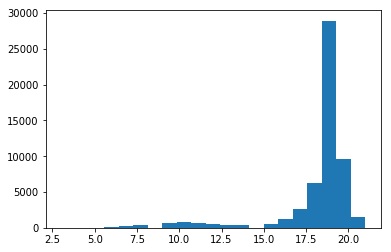

In [6]:
print('The median accuracy is: {}'.format(average_accuracy.median(axis=1)[0]))
print('The mean accuracy is:   {}'.format(average_accuracy.mean(axis=1)[0]))
plt.hist(correct['num_correct'], bins=21)
plt.show()

In [7]:
# compute accuracy of each algorithm
pd.DataFrame(train_data_unlabeled.mean()).transpose()

,ALG1,ALG2,ALG3,ALG4,ALG5,ALG6,ALG7,ALG8,ALG9,ALG10,...,ALG12,ALG13,ALG14,ALG15,ALG16,ALG17,ALG18,ALG19,ALG20,ALG21
0,0.890491,0.928382,0.997109,0.928055,0.999109,0.131473,0.871055,0.174564,0.927764,0.957655,...,0.926127,0.924655,1.0,1.0,0.885,0.929709,0.923873,0.999109,0.983309,0.996382


## Design of Project
Our initial goal was to build a regression model whose input is an MNIST image, and whose output predicts the percentage of algorithms that would classify it correctly (PERCENT_CORRECT). From there, we would determine a threshold to classify these images as EASY or HARD to classify. The rationale was the assumption that certain features that lead to misclassification may appear to different degrees. That is, these are not binary features. As such, it seems that we would lose information if we were to just train on EASY/HARD labels rather than PERCENT_CORRECT.

However, the regression model did not converge, and given our time/compute constraints, we opted to resort to the binary classification model. Our classifier is a two-layer MLP, with hidden dimensions 1024 and 128. The results of this are shown below.

## Basic Classifier

Here, we create a MLP that attempts to predict the percent of classifiers that correctly classified an image. 

In [61]:
# Data
def aggregator(row):
    return int(row.sum() > 18)

train_x = mnist.train.images
train_y = train_data_unlabeled.apply(aggregator, axis=1).reset_index().drop('ID', axis=1)
train_y_one_hot = tf.Session().run(tf.one_hot(train_y, 2)).reshape((-1,2))

val_x = mnist.validation.images
val_y = val_data_unlabeled.apply(aggregator,axis=1).reset_index().drop('ID', axis=1)
val_y_one_hot = tf.Session().run(tf.one_hot(val_y, 2)).reshape((-1,2))

test_x = mnist.test.images
test_y = test_data_unlabeled.apply(aggregator, axis=1).reset_index().drop('ID', axis=1)
test_y_one_hot = tf.Session().run(tf.one_hot(test_y, 2)).reshape((-1,2))

In [118]:
classifier = mlp.MLP(train_x, train_y_one_hot, './save', hidden_1=1024, hidden_2=128)

In [129]:
classifier.train(training_epochs=0)

INFO:tensorflow:Restoring parameters from ./save
Optimization Finished!


In [132]:
train_acc = classifier.accuracy(train_x, train_y_one_hot)
val_acc   = classifier.accuracy(val_x, val_y_one_hot)
test_acc  = classifier.accuracy(test_x, test_y_one_hot)

print('Train Accuracy: {}'.format(train_acc))
print('Val Accuracy:   {}'.format(val_acc))
print('Test Accuracy:  {}'.format(test_acc))

INFO:tensorflow:Restoring parameters from ./save
INFO:tensorflow:Restoring parameters from ./save
INFO:tensorflow:Restoring parameters from ./save
Train Accuracy: 0.7108727097511292
Val Accuracy:   0.7368000149726868
Test Accuracy:  0.670799970626831


## Future Direction
We saw, in the analysis of the training data, that two algorithms, ALG14 and ALG15 consistently had the correct predictions. It follows that they contribute nothing to the learner. On the other hand, ALG6 obtained a 0.131 accuracy (note that guessing at random should obtain about 0.10 accuracy). This suggests that we should take these accuracies into account when generating the EASY/HARD classification. 

It is unsurprising if a classifier that is near random classifies an image incorrectly, and therefore, we should take that less into account when deciding when an image is EASY/HARD. Conversely, if an algorithm that is almost always correct errs, then we should give more weight to that error.

In fact, generating EASY/HARD labels using the weighted accuracies may reflect more 'real' features in the data (e.g. reducing noise from poor/near-random classifiers).

We also may consider using different representations of MNIST images. Similar to word embeddings, we can take the last hidden layer of the output of a CNN (trained on the original MNIST problem of classifying digits) as the representation of the image. This may allow relevant features to be more readily accessible and tied with the EASY/HARD labels as well.